# IMMC 2020: Testing of Layouts
### Importing Modules and Data

In [1]:
import pandas as pd
import copy
import re
import random
import math, statistics
import numpy as np
import progressbar
import gc
import matplotlib.pyplot as plt
from pprint import pprint

median_income = 9733/365
loss_aversion_coefficient = 2
max_shelf_capacity = 150
max_shopper_capacity = 300
units_per_object = 1
max_pdt_per_shelf = 3
pdts_per_shopper = 3
crowd_avoidance = 0.5
mean_shopper_size=50 #mean size of shopper

pdt_csv_data = pd.read_csv("StoreData_IMMC_CSV.csv")
#print(pdt_csv_data.head())

In [2]:
def sigmoid(x):
    return 1 / (1 + math.exp(-x))

## Determining the Popularity of Product
### Impact of Discount on Popularity

In [3]:
# Traditional Econs Approach
def q1_over_q0(p0, p1, percentage_usage):
    x = (p0 - p1)*(percentage_usage/median_income) 
    return (math.exp(x))

# Behavioural Econs Approach
def prospect_utility(x):
    if x > 0:
        return(math.log(x+1))
    else:
        return(-loss_aversion_coefficient * math.log(-x + 1))

def increase_utility(p0, p1):
    return(prospect_utility(p0 - p1))

# Helper Variables
max_increase_utility = increase_utility(3329.99, 2199.99)
min_increase_utility = 0
max_q1_over_q0 = q1_over_q0(3329.99, 2199.99, 1)
min_q1_over_qo = 1

# Combined Effect [Between 0 and 1]
def popularity_due_to_discount(p0, p1, percentage_usage):
    traditional_econs_adjusted = (q1_over_q0(p0, p1, percentage_usage)-min_q1_over_qo)/max_q1_over_q0
    behavioural_econs_adjusted = (increase_utility(p0, p1)-min_increase_utility)/max_increase_utility

    total_adjusted = statistics.mean([traditional_econs_adjusted, behavioural_econs_adjusted])
    return(total_adjusted)

### Effect of Loss Adversion on Popularity

In [4]:
# [Between 0 and 1]
def popularity_due_to_loss_aversion(qty):
    return(math.exp(-qty/loss_aversion_coefficient))

### Effects of Saliency Bias on Popularity (TO DO)

In [5]:
def popularity_due_to_saliency_bias(size, qty):
    return sigmoid(size*qty)

### Effects of Ratings on Popularity

In [6]:
# [Between 0 and 1]
def popularity_due_to_rating(pdt_rating, brand_rating):
    raw_brand = (0.8*pdt_rating + 0.2*brand_rating)
    return(raw_brand/5)

## Creating Product Class and List

In [7]:
class product:
    # Popularity Coefficients
    pop_loss_adversion_coefficient = 0.44
    pop_saliency_coefficient = 0.6
    pop_rating_coefficient = 0.5
    
    
    # Raw Data
    def __init__(self, index, name, department, product_category, product_type, brand, initial_price, discounted_price, qty, customer_rating, brand_rating=5, percentage_usage=0.5, size=20):
        self.name = name
        self.index = index
        self.department = department
        self.product_category = product_category
        self.product_type = product_type
        self.brand = brand
        self.initial_price = initial_price
        self.discounted_price = discounted_price
        self.qty = qty
        self.customer_rating = customer_rating
        self.brand_rating = brand_rating
        self.percentage_usage = percentage_usage
        self.size = size
        
        self.popularity = 0
    
    # Processed Data
    
    def set_popularity(self):
        discount_factor = popularity_due_to_discount(self.initial_price, self.discounted_price, self.percentage_usage)
        loss_adversion_factor = popularity_due_to_loss_aversion(self.qty)
        saliency_factor = popularity_due_to_saliency_bias(self.size, self.qty)
        rating_factor = popularity_due_to_rating(self.customer_rating, self.brand_rating)
        
        initial_popularity = self.pop_loss_adversion_coefficient*loss_adversion_factor + self.pop_saliency_coefficient*saliency_factor + self.pop_rating_coefficient*rating_factor
        self.popularity = sigmoid(initial_popularity + discount_factor)

In [8]:
# Populating the Product List
pdt_list = []
pdt_counter = 0
for index, row in pdt_csv_data.iterrows():
    
    total_qty = row["qty"]
    unit_size = row["index_size"]
    while True:
        
        cur_qty = min(min(int(max_shelf_capacity/unit_size), total_qty), units_per_object)
        # print("index", index, "department", row["department"], "qty", cur_qty, "net_size", cur_qty*unit_size)
        total_qty -= cur_qty
        
        cur_pdt = product(index, row["name"], row["department"], row["product_category"], row["product_type"], row["brand"], row["initial_price"], row["discounted_price"], cur_qty, row["customer_rating"], size=unit_size, brand_rating=row["brand_rating"], percentage_usage=row["percentage_usage"])
        cur_pdt.set_popularity()
        
        pdt_counter += 1
        pdt_list.append(cur_pdt)
        
        if total_qty <=0:
            break

print("pdt_list len", len(pdt_list))
print("Number of products", pdt_counter)

pdt_list len 1535
Number of products 1535


In [9]:
department_popularities = {
    "Appliances": 0,
    "Audio": 0,
    "Cameras": 0,
    "Cell Phones": 0,
    "Computers&Tablets": 0,
    "TV&Home Theater": 0,
    "Video Gaming": 0
}
department_qty = {
    "Appliances": 0,
    "Audio": 0,
    "Cameras": 0,
    "Cell Phones": 0,
    "Computers&Tablets": 0,
    "TV&Home Theater": 0,
    "Video Gaming": 0
}


total_objects = 0
for department, total_pop in department_popularities.items():
    number_of_objects = 0
    for pdt in pdt_list:
        if pdt.department == department:
            number_of_objects += 1
    total_objects += number_of_objects
    print("Department:", department, "Number of Objects", number_of_objects)
    
print("Total Number of Objects", len(pdt_list))

print("--------")

total_pop = 0
for pdt in pdt_list:
    department_popularities[pdt.department]+= pdt.popularity*pdt.qty
    department_qty[pdt.department]+= pdt.qty
    total_pop += pdt.popularity*pdt.qty

for department, pop in department_popularities.items():
    print("Department:", department, "Average Popularity", pop/department_qty[department])
print("Global Average Popularity:", total_pop/len(pdt_list))


Department: Appliances Number of Objects 257
Department: Audio Number of Objects 50
Department: Cameras Number of Objects 165
Department: Cell Phones Number of Objects 55
Department: Computers&Tablets Number of Objects 444
Department: TV&Home Theater Number of Objects 383
Department: Video Gaming Number of Objects 181
Total Number of Objects 1535
--------
Department: Appliances Average Popularity 0.8389350550900967
Department: Audio Average Popularity 0.7909613754768059
Department: Cameras Average Popularity 0.8028821374113138
Department: Cell Phones Average Popularity 0.7798840389861017
Department: Computers&Tablets Average Popularity 0.814878007267299
Department: TV&Home Theater Average Popularity 0.8321277481983057
Department: Video Gaming Average Popularity 0.8275033824709389
Global Average Popularity: 0.8213761744384271


In [10]:
pdt_list[4].index

0

## Creating Shelf Class and Layout Object

In [11]:
class shelf:
    # Class Variables
    
    def __init__(self, department):
        self.pdts = []
        self.pdt_set = set()
        self.department = department
        self.cur_capacity = 0
    
    def add_pdt(self, pdt):
        # Check Department
        # print("Adding Product")
        # print("  product_department", pdt.department)
        # print("  shelf_department", self.department)
        if pdt.department != self.department:
            return -1
        
        # If shelf can accomodate the product
        if self.cur_capacity + pdt.size*pdt.qty <= max_shelf_capacity:
            self.cur_capacity += pdt.size*pdt.qty
            self.pdts.append(pdt)
            self.pdt_set.add(pdt.index)
            return 0
        
        # If shelf is full
        return -1

In [12]:
class layout:
    
    def __init__(self, grid, counter, entrance, exit, shelf_list=[], pdt_list=[]):
        self.counter = counter
        self.value_of_goods_bought = 0
        self.shopper_size = 0
        self.entrance = entrance
        self.exit = exit
        
        # Grid is a 2d matrix where shelves are 1 indexed
        self.grid = copy.deepcopy(grid)
        self.shelf_list = copy.deepcopy(shelf_list)
        
        # A* Grid is a grid where shelves are labelled as 1
        self.a_star_grid = copy.deepcopy(grid)
        for i in range(len(self.a_star_grid)):
            for j in range(len(self.a_star_grid)):
                if self.a_star_grid[i][j] > 1:
                    self.a_star_grid[i][j] = 1
                    
        # Shopper Density Grid is a grid to record the density of shoppers; shelves have a density of 99
        self.shopper_density_grid = copy.deepcopy(self.a_star_grid)
        for i in range(len(self.shopper_density_grid)):
            for j in range(len(self.shopper_density_grid)):
                if self.shopper_density_grid[i][j] == 1:
                    self.shopper_density_grid[i][j] = -1
                    
        # Price Density Grid is a grid to record to value of products the customers are carrying at particular locations
        self.price_density_grid = copy.deepcopy(grid)
        for i in range(len(self.price_density_grid)):
            for j in range(len(self.price_density_grid)):
                if self.price_density_grid[i][j] > 0:
                    self.price_density_grid[i][j] = 0
                    
                    
        # pdt_list contains the products that exists somewhere within the layout
        self.pdt_list = copy.deepcopy(pdt_list)
        
        
        
    # A_Star Performs a simulation of a person walking within the layout from init to goal
    # A_Star Returns a list of nodes visited on the path
    # Coordinates are written as [y,x] with [0,0] being the upper left hand corner
    def a_star(self, init, goal): 
        grid = copy.deepcopy(self.a_star_grid)
        cost = 1

        # the cost map which pushes the path closer to the goal
#         heuristic = [[0 for row in range(len(grid[0]))] for col in range(len(grid))]
#         for i in range(len(grid)):
#             for j in range(len(grid[0])):
#                 heuristic[i][j] = abs(i - goal[0]) + abs(j - goal[1])
#                 if grid[i][j] == 1:
#                     heuristic[i][j] = 99  # added extra penalty in the heuristic map

        heuristic = [[0 for row in range(len(grid[0]))] for col in range(len(grid))]
        for i in range(len(grid)):
            for j in range(len(grid[0])):
                heuristic[i][j] = abs(i - goal[0]) + abs(j - goal[1])
                if grid[i][j] == 1:
                    heuristic[i][j] = 9999999  # added extra penalty in the heuristic map
                else:
                    heuristic[i][j] = crowd_avoidance * self.shopper_density_grid[i][j]



        # the actions we can take
        

        delta = [[-1, 0], [0, -1], [1, 0], [0, 1]]  # go up  # go left  # go down  # go right
        # function to search the path
        def search(grid, init, goal, cost, heuristic):
            
            
            
            closed = [
                [0 for col in range(len(grid[0]))] for row in range(len(grid))
            ]  # the reference grid
            closed[init[0]][init[1]] = 1
            action = [
                [0 for col in range(len(grid[0]))] for row in range(len(grid))
            ]  # the action grid

            x = init[0]
            y = init[1]
            g = 0
            f = g + heuristic[init[0]][init[0]]
            cell = [[f, g, x, y]]

            found = False  # flag that is set when search is complete
            resign = False  # flag set if we can't find expand

            while not found and not resign:
                if len(cell) == 0:
                    return "FAIL"
                else:
                    cell.sort()  # to choose the least costliest action so as to move closer to the goal
                    cell.reverse()
                    next = cell.pop()
                    x = next[2]
                    y = next[3]
                    g = next[1]

                    if x == goal[0] and y == goal[1]:
                        found = True
                    else:
                        for i in range(len(delta)):  # to try out different valid actions
                            x2 = x + delta[i][0]
                            y2 = y + delta[i][1]
                            if x2 >= 0 and x2 < len(grid) and y2 >= 0 and y2 < len(grid[0]):
                                if closed[x2][y2] == 0 and grid[x2][y2] == 0:
                                    g2 = g + cost
                                    f2 = g2 + heuristic[x2][y2]
                                    cell.append([f2, g2, x2, y2])
                                    closed[x2][y2] = 1
                                    action[x2][y2] = i
            invpath = []
            x = goal[0]
            y = goal[1]
            invpath.append([x, y])  # we get the reverse path from here
            while x != init[0] or y != init[1]:
                x2 = x - delta[action[x][y]][0]
                y2 = y - delta[action[x][y]][1]
                x = x2
                y = y2
                invpath.append([x, y])

            path = []
            for i in range(len(invpath)):
                path.append(invpath[len(invpath) - 1 - i])
                
#             print("ACTION MAP")
#             for i in range(len(action)):
#                 print(action[i])

            return path
        return search(grid, init, goal, cost, heuristic)
    
    # Simulates Choice of Object to Buy and Deletes that Object from Object List
    def choose_pdt(self):
        if len(self.pdt_list) == 0:
            print("RAN OUT OF ITEMS IN SHOP")
            return -1
        self.pdt_list.sort(key=lambda x: x.popularity, reverse=True)
        index = min(random.randint(0, 5), len(self.pdt_list) -1)
        chosen_pdt = copy.deepcopy(self.pdt_list[index])
        return chosen_pdt
    
    def delete_pdt(self, product_index):
        for i in range(len(self.pdt_list)):
            if self.pdt_list[i].index == product_index:
                
                if self.pdt_list[i].qty == 1:
                    self.pdt_list.pop(i)
                else:
                    self.pdt_list[i].qty -= 1
                    
                break
        
        return
    
    # Find Product in Sheleves
    def find_shelf(self, chosen_pdt_index):
        for shelf_index, shelf in enumerate(self.shelf_list):
                # print("Checking shelf", shelf_index)
                if chosen_pdt_index in shelf.pdt_set:
                    chosen_shelf_index = shelf_index
        return chosen_shelf_index
    
    def delete_pdt_from_shelf(self, chosen_pdt_index, shelf_index):
        # Remove product from shelf
        shelf = self.shelf_list[shelf_index]
        for i in range(len(shelf.pdts)):
            if shelf.pdts[i].index == chosen_pdt_index:
                # print("QTY of pdt", shelf.pdts[i].qty)
                    if shelf.pdts[i].qty <= 1:
                        del shelf.pdts[i]
                        
                    else:
                        shelf.pdts[i].qty-= 1
                        shelf.pdts[i].set_popularity()
                    break
        
        last_product_of_type = True
        for j in range(len(shelf.pdts)):
            if shelf.pdts[j].index == chosen_pdt_index:
                last_product_of_type = False
                # print("##@@##@###@###@#####@#@#@###@##Meow")
                break
        if last_product_of_type:
            shelf.pdt_set.discard(chosen_pdt_index)
        return
            
                        
        
    def walk(self, init, goal, cur_size, cur_price):
        def fn(y,x):
            
            if x >= 0 and x < len(self.grid) and y >= 0 and y < len(self.grid[0]):
                if goal == self.exit:
                    [y,x] = [goal[0], goal[1]]
                path = self.a_star(init, [y,x])
                if path == "FAIL":
                    z=0
                    return -1
                else:
                    for cell in path:
                        self.shopper_density_grid[cell[0]][cell[1]] += cur_size
                        self.price_density_grid[cell[0]][cell[1]] += cur_price
                    cur_pos = [y,x]
                    return cur_pos
            else:
                return -1
                
        # Conduct A*
        delta = [(-1,0), (1,0), (0,-1), (0,1)]
        random.shuffle(delta)
        for d in delta:
            y = goal[0]+d[0]
            x = goal[1]+d[1]
            new_pos = fn(y,x)
            if new_pos != -1:
                return new_pos
            
        # If the shelf is not reachable, try to each an adjacent shelf
        for d in delta:
            for d2 in delta:
                y = goal[0]+d[0]+d2[0]
                x = goal[1]+d[1]+d2[1]
                new_pos = fn(y,x)
                if new_pos != -1:
                    return new_pos
        
    # Simulates a person entering shop
    def new_shopper(self):
        max_number_of_products = pdts_per_shopper
        max_size = max_shopper_capacity
        
        cur_number_of_pdt = 0
        cur_size = random.randint(mean_shopper_size-10, mean_shopper_size+10)
        cur_price = 0
        
        
        # Random Entrance Square
        cur_pos = random.choice(self.entrance)
        
        if len(self.pdt_list) == 0:
            return -1
        while cur_size < max_size and cur_number_of_pdt < 3 and len(self.pdt_list) > 0:
            
            # Choose what Product to Buy
            chosen_pdt = self.choose_pdt()
            if cur_size + chosen_pdt.size > max_size:
                break
            
        
            # Find Shelf Index
            chosen_shelf_index = self.find_shelf(chosen_pdt.index)
        
            # Find Location of Shelf 
            for y in range(len(self.grid)):
                for x in range(len(self.grid[0])):
                    if self.grid[y][x] == chosen_shelf_index:
                        shelf_location = (y,x)
    
            # Walk from cur_pos to another shelf while tracking the movement of the shopper
            cur_pos = self.walk(cur_pos, shelf_location, cur_size, cur_price)
            self.delete_pdt(chosen_pdt.index)
            self.delete_pdt_from_shelf(chosen_pdt.index, chosen_shelf_index)
            self.value_of_goods_bought += chosen_pdt.discounted_price
            cur_number_of_pdt +=1
            cur_price += chosen_pdt.discounted_price
            cur_size += chosen_pdt.size
        
        # Walk to Counter
        cur_pos = self.walk(cur_pos, random.choice(self.counter), cur_size, cur_price)
        cur_pos = self.walk(cur_pos, random.choice(self.exit), cur_size, 0)
        
        self.shopper_size += cur_size
                
        return 0
        
    # Get adjusted Price Grid
    def get_price_grid(self):
        total_price = 0
        for i in range(len(self.price_density_grid)):
            for j in range(len(self.price_density_grid)):
                total_price += self.price_density_grid[i][j]
        
        adjusted_grid = copy.deepcopy(self.price_density_grid)
        for i in range(len(self.price_density_grid)):
            for j in range(len(self.price_density_grid)):
                adjusted_grid[i][j] *= (self.value_of_goods_bought/total_price)
                adjusted_grid[i][j] = int(adjusted_grid[i][j])
        
        return adjusted_grid
    
    def get_shopper_grid(self):
        total_size = 0
        for i in range(len(self.shopper_density_grid)):
            for j in range(len(self.shopper_density_grid)):
                total_size += self.shopper_density_grid[i][j]
        
        adjusted_grid = copy.deepcopy(self.shopper_density_grid)
        for i in range(len(self.shopper_density_grid)):
            for j in range(len(self.shopper_density_grid)):
                adjusted_grid[i][j] *= (self.shopper_size/total_size)
                adjusted_grid[i][j] = int(adjusted_grid[i][j])
        
        return adjusted_grid
    
    # Collision Damage / Self-Drops
    def loss(self, shopper_density, price_density):
        p_collision = (min(shopper_density, 300)) **2 / (300*300)
        return p_collision*price_density

    def total_loss(self):
        shopper_density_grid = self.get_shopper_grid()
        price_density_grid = self.get_price_grid()
        
        net_loss = 0
        for y in range(len(shopper_density_grid)):
            for x in range(len(shopper_density_grid)):
                net_loss += self.loss(shopper_density_grid[y][x], price_density_grid[y][x])

        return net_loss


# Simulate Layout in Figure 1

## Simulation Cells

In [13]:
template='''
ffffffffffffffffffffffffffffffffffffffffffffffff
000000000000000000000000000000000000000000000000
0gg00000000000000000000000000000000000ffffff000f
0gg000000000000000000000000000000000000000ff000f
0gg000000000000000000000000000000000000000ff000f
0gg00dd0000eeeeee00000eeeeee00000000000000ff000f
0gg00dd0000eeeeee00000eeeeee00000000000000ff000f
0gg00dd0000000000000000000000000000000000000000f
0gg00dd0000eeeeee000000eeeeeeee0000cccc00000000f
0gg00dd0000eeeeee000000eeeeeeee0000cccc000ff000f

0gg00dd00000000000000000000000000000000000ff000f
0gg00dd0000eeeeee000000eeeeeeee00000000000ff000f
0gg00dd0000eeeeee000000eeeeeeee0000cccc000ff000f
0gg00dd0000000000000000000000000000cccc00000000f
0gg00dd0000eeeeee000000eeeeeeee0000000000000000f
0gg00000000eeeeee000000eeeeeeee00000000000ff000f
0gg00000000000000000000000000000000cccc000ff000f
0gg00000000eeeeee000000eeeeeeee0000cccc000ff000f
0gg00000000eeeeee000000eeeeeeee00000000000ff000f
0gg00000000000000000000000000000000000000000000f

0gg00bb0000eeeeee00000eeeeee0000000cccc00000000f
0gg00bb0000eeeeee00000eeeeee0000000cccc000ff000f
0gg00bb00000000000000000000000000000000000ff000f
0gg00bb00000000000000000000000000000000000ff000f
0gg00bb0000000000000000000000000000cccc000ff000f
0gg00bb0000000000000000000000000000cccc00000000f
0gg00bb00aa00aa00aa00aa00aa00aa0000000000000000f
0gg00bb00aa00aa00aa00aa00aa00aa00000000000ff000f
00000bb00aa00aa00aa00aa00aa00aa0000cccc000ff000f
00000bb00aa00aa00aa00aa00aa00aa0000cccc000ff000f

000000000aa00aa00aa00aa00aa00aa00000000000ff000f
000000000aa00aa00aa00aa00aa00aa0000000000000000f
00000000000000000000000000000000000cccc00000000f
00000000000000000000000000000000000cccc00000000f
00000000000000000000000000000000000000000000000f
00000gg00aa00aa00aa00aa00aa00aa0000000000000000f
00000gg00aa00aa00aa00aa00aa00aa0000ggcc00000000f
00000gg00aa00aa00aa00aa00aa00aa0000ggcc00000000f
00000gg00aa00aa00aa00aa00aa00aa0000000000000000f
00000000000000000000000000000000000000000000000f

00000000000000000000000000000000000000000000000f
00000000000000000000000000000000000000000000000f
00000000000000000000000000000000000000000000000f
00000000000000000000000000000000000000000000000f
000000000000000000000000000000000000000000000000
000000000000000000000000000000000000000000000000
000000000000000000000000000000000000000000000000
000000000000000000000000000000000000000000000000
'''
departments = ["a","f","c","d","e","b","g"]

def generate_layout(a,f):
    if a == f:
        return ""
    index = 2
    department_used = [0,0,0,0,0,0,0,0] # Whether the number has been used
    department_used[a] =department_used[f] = 1 
    print("A:", a, "F:",f)
    layout = (template)
    layout = layout.replace(str(a), "a")
    layout = layout.replace(str(f), "f")

    for i in range(1,8):
        if not department_used[i]:
            print("replacing", i, "with", departments[index])
            layout = layout.replace(str(i), departments[index])
            department_used[i] = 1
            index += 1
    return layout
                
# for a in range(1,8):
#     for b in range(1,8):
#         print(generate_layout(a,b))

In [14]:
def split_row(word): 
    return [char for char in word] 

def evaluate_layout(test_layout, counters = [(40, 6),(40, 7),(40, 8),(40, 9),(40, 10), (40, 11), (40,12), (40,13)]):
    # Parse Layout
    test_layout = test_layout.replace('\n\n', '\n')
    test_layout = test_layout.strip("\n")

    test_layout = test_layout.split("\n")
    for i in range(len(test_layout)):
        test_layout[i] = split_row(test_layout[i])
        
    department_dictionary = {
        "a": "Appliances",
        "b": "Audio",
        "c": "Cameras",
        "d": "Cell Phones",
        "e": "Computers&Tablets",
        "f": "TV&Home Theater",
        "g": "Video Gaming",
    }
    shelf_list = [shelf("")]
    shelf_counter = 1
    for (letter, department_name) in department_dictionary.items():
        for y in range(len(test_layout)):
            for x in range(len(test_layout)):
                if str(test_layout[y][x]) == letter:
                    # print("found shelf", shelf_counter, "department:", department_name)
                    test_layout[y][x] = str(shelf_counter)
                    shelf_counter += 1
                    shelf_list.append(shelf(department_name))

    for y in range(len(test_layout)):
        for x in range(len(test_layout)):
            if not str(test_layout[y][x]).isdigit():
                test_layout[y][x] = str(shelf_counter)
                shelf_counter +=1
            test_layout[y][x] = int(test_layout[y][x])



    max_shelf_index = shelf_counter
    
    
    # Put The Objects in Shelves
    pdt_index = 0
    pdt_list.sort(key=lambda x: x.department)

    for shelf_index in range(1, max_shelf_index):
        # print("\nShelf Index: ", shelf_index)
        cur_shelf = shelf_list[shelf_index]
        # print("Shelf Department -- ", cur_shelf.department)

        for i in range(max_pdt_per_shelf):
            next_pdt = copy.deepcopy(pdt_list[pdt_index])
            if next_pdt.department == "Appliances" and cur_shelf.department != "Appliances":
                print("Insufficient Appliance Space")
                return 9999999
            # print("Products Department", next_pdt.department)
            if cur_shelf.add_pdt(next_pdt) != -1:
                # print("Added pdt id", next_pdt.index)
                pdt_index += 1
                if pdt_index == len(pdt_list):
                    break
            else:
                break
        # print("Products in shelf" , shelf_index, ":", cur_shelf.pdt_set)

        if pdt_index == len(pdt_list):
            if next_pdt.department != "Video Gaming":
                print("ERROR INSUFFICIENT SHELVES")
                return 9999999
            print("--- Finished All Products with", shelf_index, "out of", max_shelf_index, "shelves --- ")
            break
            
    # Set up Object
    ## Test Layout with Model
    # counters = [(40, 6),(40, 7),(40, 8),(40, 9),(40, 10), (40, 11), (40,12), (40,13)]
    entrances = [[47,30],[47,29],[47,28]]
    exits = [[48,35],[48,36],[48,37]]
    test_layout_object = layout(test_layout , counters, entrances, exits, shelf_list, pdt_list)
    # print("Number of products in layout:", len(test_layout_object.pdt_list))
    
    
    # Do Simulation
    gc.collect()
    for i in progressbar.progressbar(range(600)):
        try:
            shopper_density_grid = test_layout_object.new_shopper()
            if shopper_density_grid == -1:
                print("Exhausted Shop with approximately", i, "shoppers")
                break
        except:
            pass
        
    # Get Results
    price_density_grid = test_layout_object.get_price_grid()
    shopper_density_grid = test_layout_object.get_shopper_grid()
    
    print("Shopper Density SD:", np.std(shopper_density_grid, axis=(0,1)))
    print("Price Density SD:", np.std(price_density_grid, axis=(0,1)))
    
    net_loss = test_layout_object.total_loss()
    print("Damage Level:", net_loss)
    
    shelf_grid = copy.deepcopy(test_layout_object.a_star_grid)
    for counter in counters:
        shelf_grid[counter[0]][counter[1]] = 0.7
    for entrance in entrances:
        shelf_grid[entrance[0]][entrance[1]] = 0.5
    for exit in exits:
        shelf_grid[exit[0]-1][exit[1]] = 0.5
    return (net_loss, price_density_grid, shopper_density_grid, shelf_grid)

# Simulate Our Layout

In [15]:
our_layout='''
ffffffffffffffffffffffffffffffffffffffffffffffff
000000000000000000000000000000000000000000000000
0gg00000000000000000000000000000000000ffffff000f
0gg000000000000000000000000000000000000000ff000f
0gg000000000000000000000000000000000000000ff000f
0gg00dd0000eeeeee00000eeeeee00000000000000ff000f
0gg00dd0000eeeeee00000eeeeee00000000000000ff000f
0gg00dd0000000000000000000000000000000000000000f
0gg00dd0000eeeeee000000eeeeeeee0000cccc00000000f
0gg00dd0000eeeeee000000eeeeeeee0000cccc000ff000f

0gg00dd00000000000000000000000000000000000ff000f
0gg00dd0000eeeeee000000eeeeeeee00000000000ff000f
0gg00dd0000eeeeee000000eeeeeeee0000cccc000ff000f
0gg00dd0000000000000000000000000000cccc00000000f
0gg00dd0000eeeeee000000eeeeeeee0000000000000000f
0gg00000000eeeeee000000eeeeeeee00000000000ff000f
0gg00000000000000000000000000000000cccc000ff000f
0gg00000000eeeeee000000eeeeeeee0000cccc000ff000f
0gg00000000eeeeee000000eeeeeeee00000000000ff000f
0gg00000000000000000000000000000000000000000000f

0gg00bb0000eeeeee00000eeeeee0000000cccc00000000f
0gg00bb0000eeeeee00000eeeeee0000000cccc000ff000f
0gg00bb00000000000000000000000000000000000ff000f
0gg00bb00000000000000000000000000000000000ff000f
0gg00bb0000000000000000000000000000cccc000ff000f
0gg00bb0000000000000000000000000000cccc00000000f
0gg00bb00aa00aa00aa00aa00aa00aa0000000000000000f
0gg00bb00aa00aa00aa00aa00aa00aa00000000000ff000f
00000bb00aa00aa00aa00aa00aa00aa0000cccc000ff000f
00000bb00aa00aa00aa00aa00aa00aa0000cccc000ff000f

000000000aa00aa00aa00aa00aa00aa00000000000ff000f
000000000aa00aa00aa00aa00aa00aa0000000000000000f
00000000000000000000000000000000000cccc00000000f
00000000000000000000000000000000000cccc00000000f
00000000000000000000000000000000000000000000000f
00000gg00aa00aa00aa00aa00aa00aa0000000000000000f
00000gg00aa00aa00aa00aa00aa00aa0000ggcc00000000f
00000gg00aa00aa00aa00aa00aa00aa0000ggcc00000000f
00000gg00aa00aa00aa00aa00aa00aa0000000000000000f
00000000000000000000000000000000000000000000000f

00000000000000000000000000000000000000000000000f
00000000000000000000000000000000000000000000000f
00000000000000000000000000000000000000000000000f
00000000000000000000000000000000000000000000000f
000000000000000000000000000000000000000000000000
000000000000000000000000000000000000000000000000
000000000000000000000000000000000000000000000000
000000000000000000000000000000000000000000000000
'''

N/A% (0 of 600) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

--- Finished All Products with 577 out of 581 shelves --- 


 85% (513 of 600) |##################    | Elapsed Time: 0:00:37 ETA:   0:00:05

Exhausted Shop with approximately 515 shoppers
Shopper Density SD: 9.191316869807244
Price Density SD: 311.266008371722
Damage Level: 4185.8410111111125


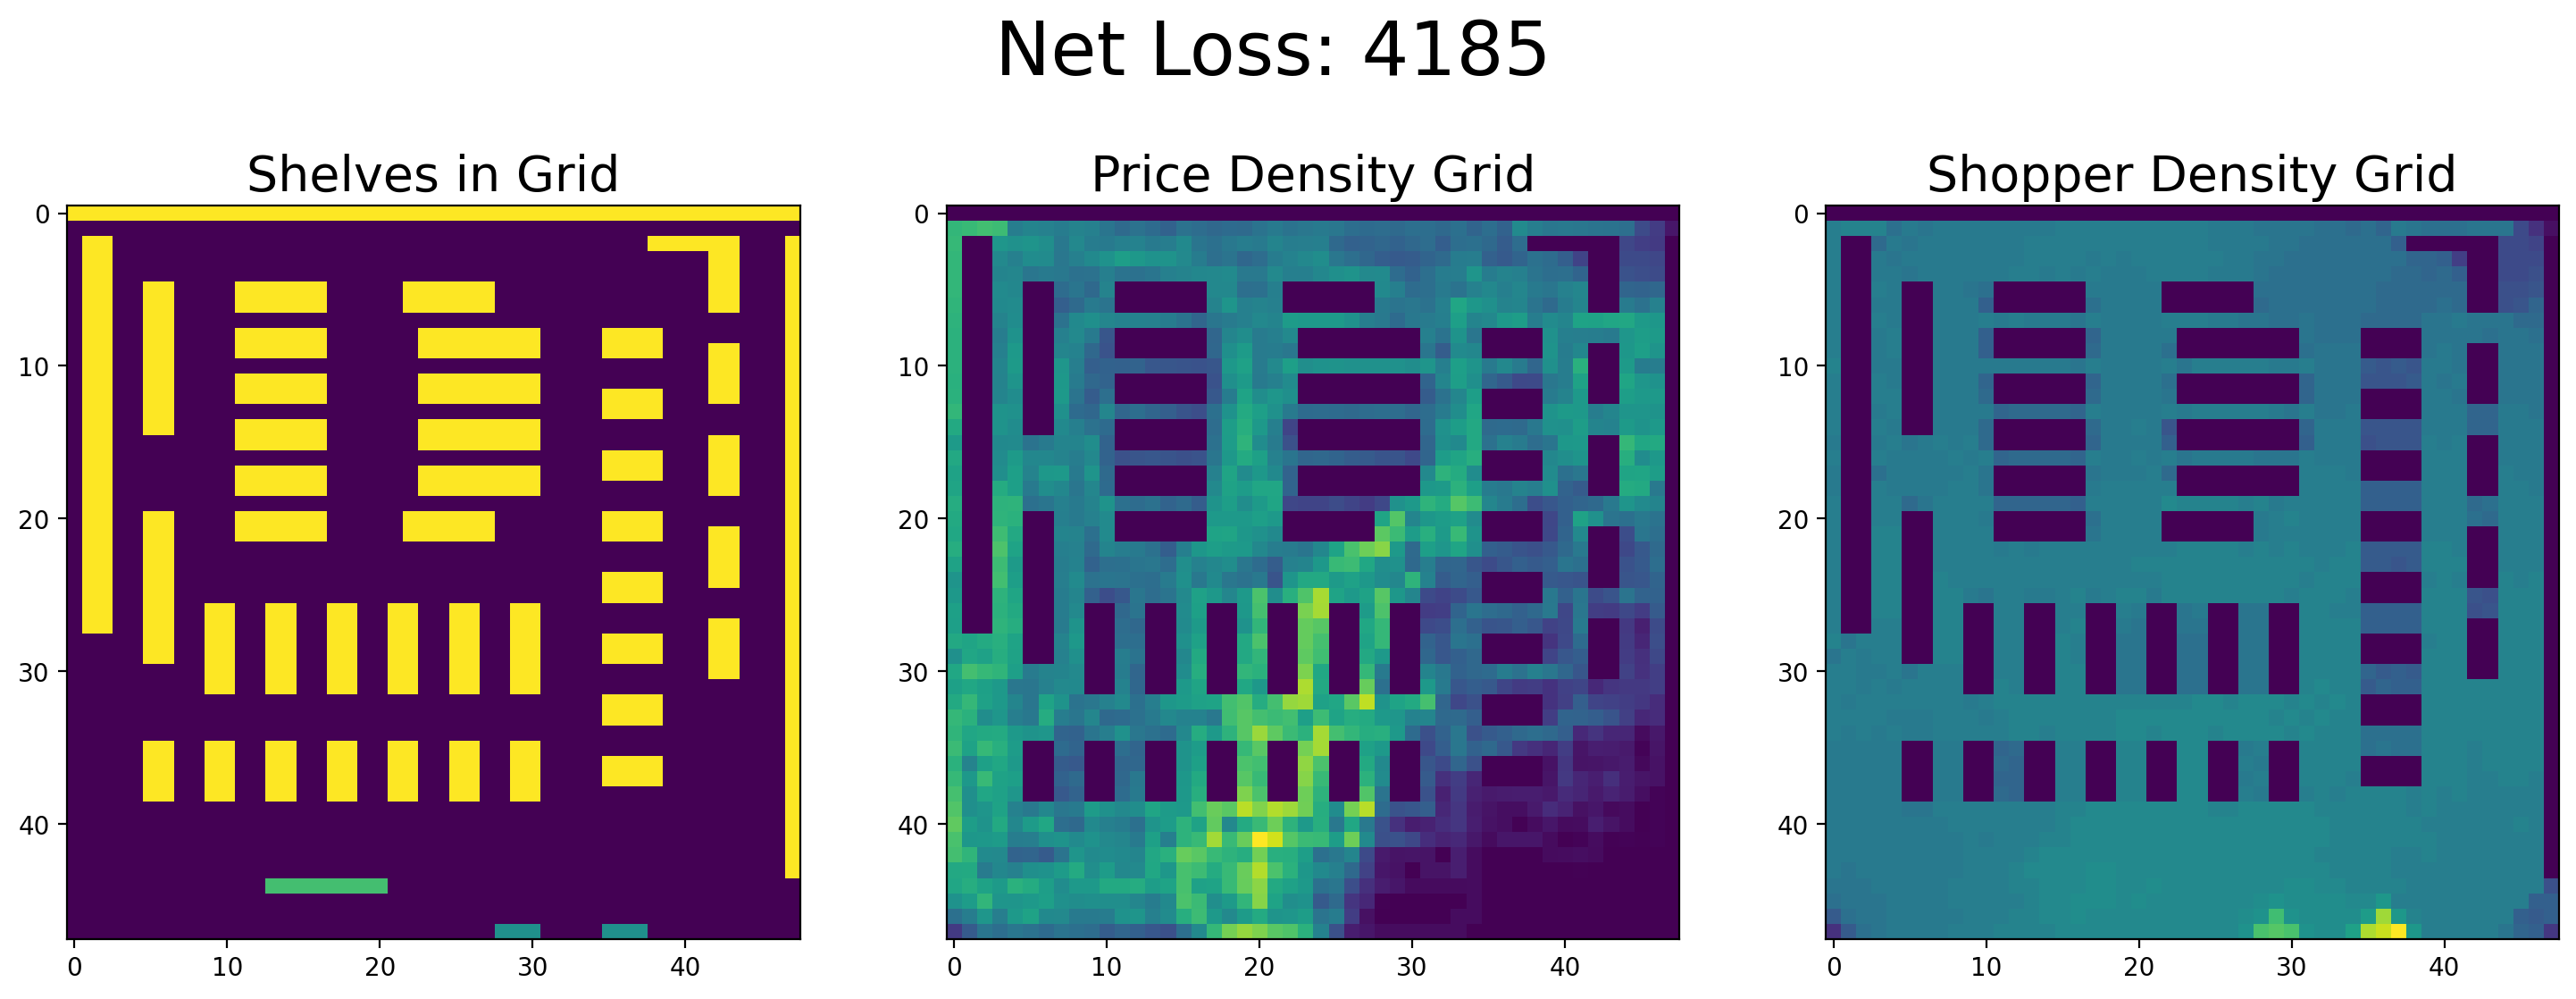

<Figure size 90000x90000 with 0 Axes>

In [16]:
a=7
f=1
# counters = [(44, 6),(44, 7),(44, 8),(44, 9),(44, 10), (44, 11), (44,12), (44,13)] # Basic Counters 
counters = [[44, 13],[44, 14],[44, 15],[44, 16],[44, 17], [44, 18], [44,19], [44,20]] # Optimised Counters
# counters = [(44, 6),(44, 7),(44, 8),(44, 9),(44, 10), (44, 11), (44,12), (44,13),[42, 25],[42, 26],[42, 27],[42, 28], [42, 29], [42,30], [42,31]] # Double Position Counters
net_loss, price_density_grid, shopper_density_grid, shelf_grid =  evaluate_layout(our_layout,counters=counters)


fig=plt.figure(figsize=(18, 6.5), dpi= 200, facecolor='w', edgecolor='k')
# plt.suptitle("A: "+ str(a) + " | F: "+ str(f), fontsize=30)
plt.suptitle("Net Loss: " + str(int(net_loss)), fontsize=30)
plt.subplot(1, 3, 1)
plt.title("Shelves in Grid",fontsize=20)
plt.imshow(shelf_grid)
plt.subplot(1, 3, 2)
plt.title("Price Density Grid",fontsize=20)
plt.imshow(price_density_grid)
plt.subplot(1, 3, 3)
plt.title("Shopper Density Grid",fontsize=20)
plt.imshow(shopper_density_grid)


plt.figure(num=None, figsize=(100, 100), dpi=900, facecolor='w', edgecolor='k')
plt.show()

## Sensitivity Test Helper Code